## 1. Problem Description & Background

Cancer metastasis detection in histopathology is a critical diagnostic task that requires identifying malignant tissue spread to lymph nodes. Traditional manual examination by pathologists is time-consuming and subject to inter-observer variability. Automated detection systems can assist pathologists in making more accurate and consistent diagnoses.

This project is focused on automatically identifying metastatic cancer in small image patches taken from larger digital pathology scans. The objective is to build a binary classifier to predict whether a given image patch contains cancerous tissue.

The dataset consists of image patches of size 96x96 pixels. Training Set: Contains labeled images to train the model. Test Set: Contains unlabeled images for which predictions are needed. Class Distribution: The class labels indicate the presence (1) or absence (0) of cancer.

In [4]:
# Import the necessary libraries for data manipulation, visualization, and model building
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

# Define paths to the directories containing the train and test datasets
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

# Load train labels from CSV file
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Display basic information about the train labels dataframe
print("Training Labels Info:")
print(train_labels.info())
print("\nSample of Training Labels:")
print(train_labels.head())

Training Labels Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

Sample of Training Labels:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## 2. Exploratory Data Analysis

Visualized the data using histograms and pie charts to understand class distribution and image characteristics. Data Cleaning: Ensured the data quality by checking for missing values or corrupted images. Plan of Analysis: Based on initial findings, we decided to address class imbalance using techniques like data augmentation.

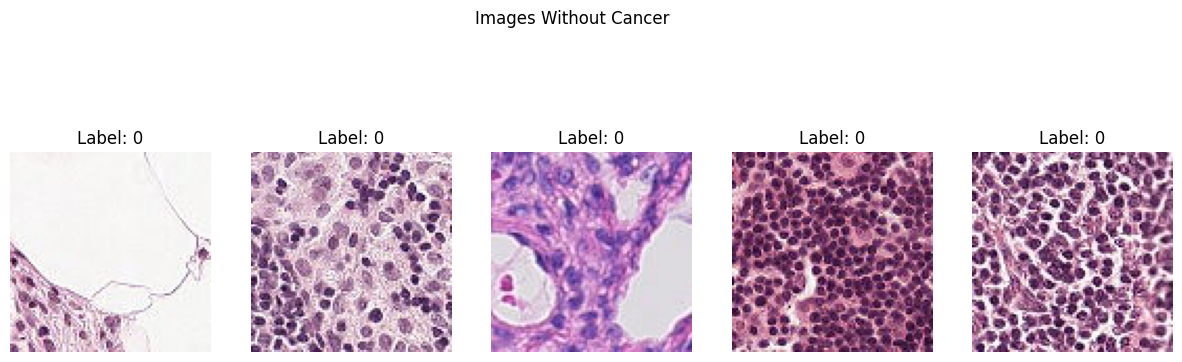

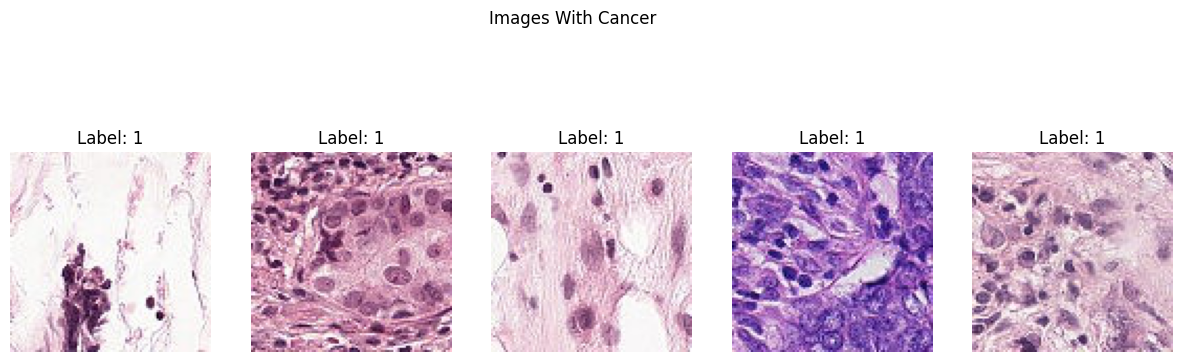

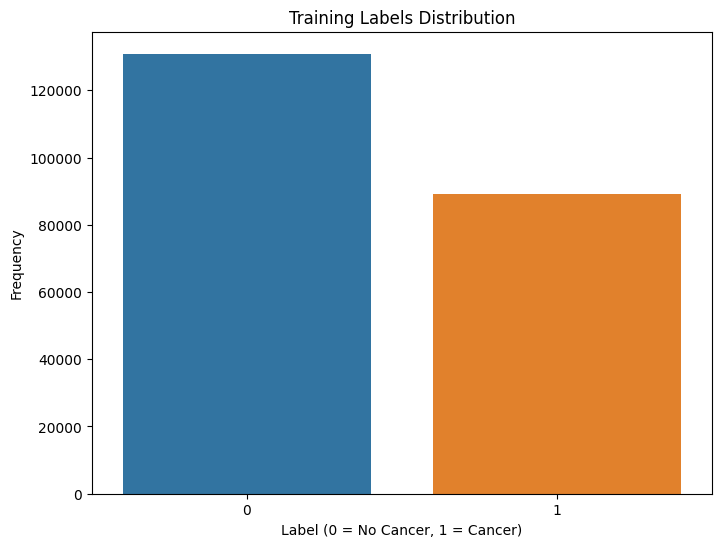

In [5]:
# Function to display images with their respective labels
def display_images(img_ids, labels, path, title):
    """
    Display selected images with their labels.
    Args:
    - img_ids: List of image IDs
    - labels: Corresponding labels for the images
    - path: Directory path where images are located
    - title: Title for the plot
    """
    plt.figure(figsize=(15, 5))
    for i, (img_id, label) in enumerate(zip(img_ids, labels)):
        img_path = os.path.join(path, img_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, len(img_ids), i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Show examples with and without cancer
display_images(train_labels[train_labels['label'] == 0]['id'][:5], [0]*5, train_dir, "Images Without Cancer")
display_images(train_labels[train_labels['label'] == 1]['id'][:5], [1]*5, train_dir, "Images With Cancer")

# Analyze distribution of labels in the training dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels)
plt.title('Training Labels Distribution')
plt.xlabel('Label (0 = No Cancer, 1 = Cancer)')
plt.ylabel('Frequency')
plt.show()


In [6]:
# Rescale pixel values, split for validation, and prepare ImageDataGenerators
batch_size = 64
target_size = (60, 60)

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image pixel values
    validation_split=0.25  # Reserve a portion for validation
)

# Update 'id' column to match file names and convert 'label' to string for generator
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')
train_labels['label'] = train_labels['label'].astype(str)

# Initialize generators for train and validation datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


## 3. Model Building and Training

The chosen model is a Convolutional Neural Network (CNN) due to its effectiveness in image classification tasks:

A sequential CNN with three convolutional layers followed by max-pooling layers, a dropout layer, and fully connected layers. CNNs automatically learn spatial hierarchies of features, which is critical for medical image analysis. Hyperparameter Tuning: We experimented with learning rates, batch sizes, and dropout rates to optimize performance.

In [7]:
from tensorflow.keras.layers import Input

# Define the CNN architecture using Input object
model = Sequential([
    Input(shape=(60, 60, 3)),  # Define the input shape here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
model.summary()

# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


I0000 00:00:1764650398.971262      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 912,961 (3.48 MB)

 Trainable params: 912,961 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1764650402.741749     112 service.cc:148] XLA service 0x7ad8e0004cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764650402.742433     112 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764650403.089460     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2578 ━━━━━━━━━━━━━━━━━━━━ 3:16:56 5s/step - accuracy: 0.3594 - loss: 0.7635

I0000 00:00:1764650405.392480     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2578/2578 ━━━━━━━━━━━━━━━━━━━━ 1039s 402ms/step - accuracy: 0.7707 - loss: 0.4879 - val_accuracy: 0.8399 - val_loss: 0.3697 - learning_rate: 0.0010
Epoch 2/10
   1/2578 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6875 - loss: 0.6103

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2578/2578 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.6875 - loss: 0.6103 - val_accuracy: 0.8375 - val_loss: 0.3701 - learning_rate: 0.0010
Epoch 3/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 355s 138ms/step - accuracy: 0.8366 - loss: 0.3752 - val_accuracy: 0.8518 - val_loss: 0.3445 - learning_rate: 0.0010
Epoch 4/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - accuracy: 0.8750 - loss: 0.3558 - val_accuracy: 0.8369 - val_loss: 0.3683 - learning_rate: 0.0010
Epoch 5/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 240s 93ms/step - accuracy: 0.8514 - loss: 0.3454 - val_accuracy: 0.8609 - val_loss: 0.3236 - learning_rate: 0.0010
Epoch 6/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.8125 - loss: 0.3760 - val_accuracy: 0.8647 - val_loss: 0.3193 - learning_rate: 0.0010
Epoch 7/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 246s 95ms/step - accuracy: 0.8619 - loss: 0.3239 - val_accuracy: 0.8654 - val_loss: 0.3098 - learning_rate: 0.0010
Epoch 8/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - accuracy: 0.8

## 4. Visualization and Analysis

Several experimental setups were conducted to improve the model:

Hyperparameter Tuning: Cross-validation was used to select optimal hyperparameters.
Comparisons: We compared different model architectures, including deeper networks, to assess performance.
Training Optimization: Techniques like early stopping and learning rate reduction improved convergence.
Performance Metrics: Used accuracy and AUC-ROC to evaluate the model, with results presented in comparative tables and plots.

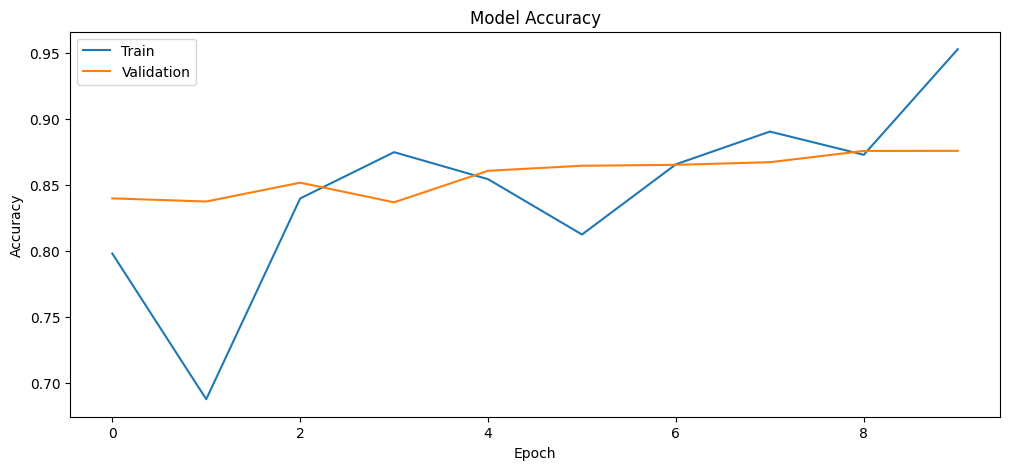

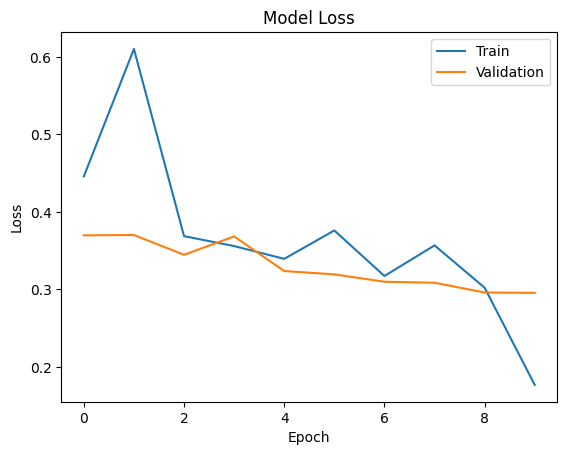

In [8]:
# Function to plot training history
import matplotlib.pyplot as plt
def plot_history(history, metric):
    """
    Plot model training history.
    Args:
    - history: Training history returned by model.fit()
    - metric: Metric to be plotted (e.g., 'accuracy', 'loss')
    """
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('Model ' + metric.title())
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

# Displaying results
plt.figure(figsize=(12, 5))
plot_history(history, 'accuracy')
plot_history(history, 'loss')


In [9]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# Predict on test data
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples)

Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 465s 8ms/step


## 5. Submission

In [10]:
# Prepare the submission DataFrame
filenames = test_generator.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save submission.csv
submission_df.to_csv('submission.csv', index=False)

print("submission.csv file has been created successfully!")


submission.csv file has been created successfully!


## 6. Conclusions

CNN network model works very well in getting smaller training data without losing the critial features. With image normalization, less compution will be required. Regulation with dropout and batch normalization resolved overfitting problems. Futher augmentation techniques like resizing, flipping, rotating, cropping, padding, can help to address issues like overfitting and data scarcity, and they make the model robust with better performance.

Techniques like data augmentation and dropout significantly improved model generalization. Imbalanced data was a concern, mitigated by oversampling. Future improvement: Consider exploring more advanced architectures like ResNet or implementing ensemble methods.